In [3]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt

STUDENT_NR_MAURITS = 14014777
STUDENT_NR_HARSHITA = 13807609

SEED = STUDENT_NR_MAURITS + STUDENT_NR_HARSHITA
random.seed(SEED)


# M/M/m Queue Model(FIFO)
## In the customer function we have put a condition for steady state after analysing the behavior(shown in the below section)

In [160]:
# simpy works in minutes
# Here system is a shop
# Agent is - Customer
# Process - serving
# resource - cashier/shopkeeper
class System(object):
    def __init__(self,env,num_servers,lambda_a,mu,service_distribution,thresholdT):
        self.env = env
        self.server = simpy.Resource(env,capacity = num_servers)
        self.n = 0    # Total customers inside the shop
        self.lambd = lambda_a
        self.mu = mu
        self.serDist = service_distribution
        self.response_time = []
        self.wait_time = []
        self.queue_length = []
        self.customer = []
        self.thresholdTime = thresholdT # Time duration during which a customer is allowed to enter the system
        
    
def customer(env,system):
    arrival_time = env.now
   
    service_time = np.random.exponential(scale=1/system.mu)
    
    with system.server.request() as request_server:
        yield request_server
        
        # Steady State
        if(env.now > 250):
            waiting_time = env.now - arrival_time
            system.wait_time.append(waiting_time)
   
        
        #print('starting to serve the customer at %s' % (env.now))
        yield env.timeout(service_time)
        #print('Customer has purchades goods and is leaving the store at %s' % (env.now))
            
    response_time = env.now - arrival_time
    system.response_time.append(response_time)
    system.n =  system.n-1

    
def generate(env,system):
    # shop opens at time T1  closes at time T2 so T(Threshold Time) = T2-T1
    while(env.now <= system.thresholdTime):
        # First customer not arriving at time t = 0 but at inter_arrival time
        inter_arrival = np.random.exponential(scale=1/system.lambd)
        yield env.timeout(inter_arrival)
        env.process(customer(env,system))
        system.n += 1
        
        
def get_average(data):
    average = np.mean(data)
    return average


def observe(env,system):
    while(env.now < system.thresholdTime):
        system.queue_length.append(len(system.server.queue))  # number of customers in a queue at time t
        system.customer.append(system.n)
        #print(len(system.server.queue))
        yield env.timeout(0.5)
            
    

# Steady state Analysis - 1 simulation run and different number of customers

In [269]:
T_threshold = np.arange(0,2400,10)  # Minutes

num_servers = [1]

mu = 15      # per minute
lambd = [25/4]

In [270]:
def customer_measure_steady_state(env,system):
    arrival_time = env.now
   
    service_time = np.random.exponential(scale=1/system.mu)
    
    with system.server.request() as request_server:
        yield request_server
        
        
        waiting_time = env.now - arrival_time
        system.wait_time.append(waiting_time)
   
        
        #print('starting to serve the customer at %s' % (env.now))
        yield env.timeout(service_time)
        #print('Customer has purchades goods and is leaving the store at %s' % (env.now))
            
    response_time = env.now - arrival_time
    system.response_time.append(response_time)
    system.n =  system.n-1
    
def generate_steady(env,system):
    # shop opens at time T1  closes at time T2 so T(Threshold Time) = T2-T1
    while(env.now <= system.thresholdTime):
        # First customer not arriving at time t = 0 but at inter_arrival time
        inter_arrival = np.random.exponential(scale=1/system.lambd)
        yield env.timeout(inter_arrival)
        env.process(customer_measure_steady_state(env,system))
        system.n += 1



service_distribution = "exponential"
avg_time = []


for i in range(len(num_servers)):
    avg_time_server = []
    print(lambd[i])
    for time in T_threshold:
        # Run the simulation
        env = simpy.Environment()
        system = System(env,num_servers[i],lambd[i],mu,service_distribution,time)
        env.process(generate_steady(env,system))
        env.process(observe(env,system))
        env.run()
        avg_time_server.append(get_average(system.wait_time))
    
    avg_time.append(avg_time_server)
    
    
   

6.25


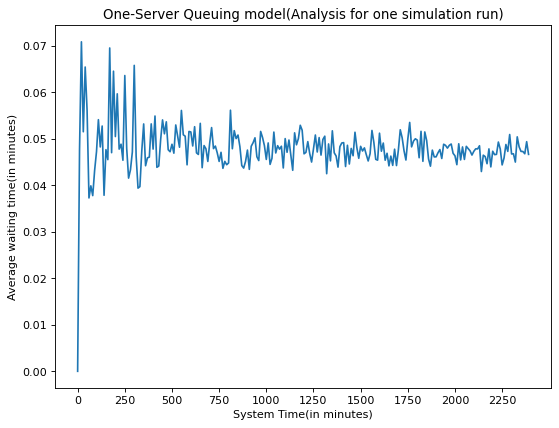

In [271]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(T_threshold,avg_time_server)
plt.title("One-Server Queuing model(Analysis for one simulation run)")
#plt.yscale("log")
plt.xlabel("System Time(in minutes)")
plt.ylabel("Average waiting time(in minutes)")

plt.xticks(np.arange(0, 2500, 250))
plt.show()

# lambda = 25/4 = 6.25 customers per minute
# for 200 minutes - 1250 customers. 

System becomes stable after Time = 250 minutes

Therefore, for steady state behavior we don't consider the waiting time for customers till Time T = 250 minutes. This is an approximation of our analysis.

# Graph of convergence of waiting time with increase in simulation runs(M/M/1)
## Taking mean time of customers only after T = 250 minutes

In [272]:
num_sim = 1500
T_threshold = 1250 # In minutes  7500 customers
num_servers = [1]

rho = 0.4
mu = 15      # per minute
lambd = [25/4]

In [273]:
service_distribution = "exponential"


def simution_run(sim,num_servers,lambd,mu,service_distribution,time):
    avg_time = []
    y_data = []
    prev_estimated_mean = 0
    for i in range(sim):
        env = simpy.Environment()
        system = System(env,num_servers,lambd,mu,service_distribution,time)
        env.process(generate(env,system))
        env.process(observe(env,system))
        env.run()
        avg_time.append(get_average(system.wait_time))
        # mean value till this simulation run
        new_mean_till_now = prev_estimated_mean + (avg_time[-1] - prev_estimated_mean)/(i+1)
        #mean_till_now = np.mean(avg_time)
        y_data.append(new_mean_till_now)
        prev_estimated_mean = new_mean_till_now
    return(y_data)
    



for i in range(len(num_servers)):
    y_data_plot = []
    y_data_plot = simution_run(num_sim,num_servers[i],lambd[i],mu,service_distribution,T_threshold)
           

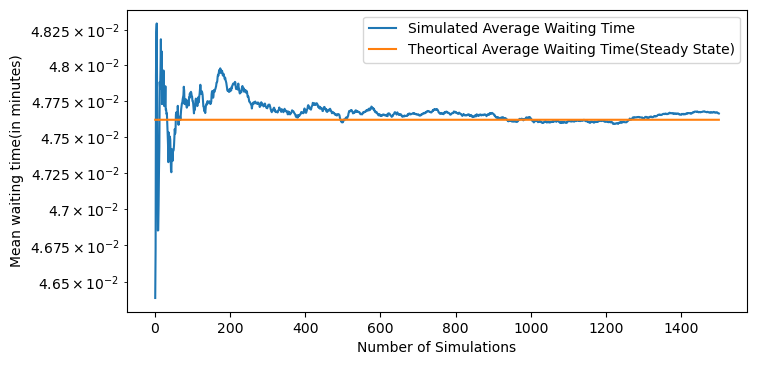

In [274]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=100)

rho = lambd[0]/mu
th_wait = rho/(mu*(1-rho))
theoritical_avg_wait = np.empty(num_sim)
theoritical_avg_wait.fill(th_wait)

x_data = np.arange(1,num_sim+1,1)
plt.plot(x_data,y_data_plot,label="Simulated Average Waiting Time")
plt.plot(x_data,theoritical_avg_wait,label="Theortical Average Waiting Time(Steady State)")
plt.legend()
plt.yscale("log")

plt.xlabel("Number of Simulations")
plt.ylabel("Mean waiting time(in minutes)")

plt.xticks(np.arange(0, 1500, 200))

plt.show()




# lambda = 25/4 = 6.25 customers per minute
# for 200 minutes - 1250 customers. 

## Based on the above analysis we choose T = 1250 minutes(approximately 7500 customers) and Simulation Runs = 500

In [224]:
T_threshold = 1250  # minutes
num_sim = 500

mu = 15
rho_arr = [0.4,0.55,0.7]
num_server = [1,2,4]


def calculate_lambda(rho,server):
        lambd_a = rho*server*mu
        return lambd_a


In [225]:
data_plot = []


for rho in rho_arr:
    for server in num_server:
        print(rho)
        print(server)
        print("\n")
        lambda_a = calculate_lambda(rho,server)
        rho_server_data = []
        avg_queue_length = []
        avg_wait_time = []
        avg_response_time = []
        avg_customers = []
        for sim in range(num_sim):
            # Run the simulation
            env = simpy.Environment()
            system = System(env,server,lambda_a,mu,service_distribution,T_threshold)
            env.process(generate(env,system))
            env.process(observe(env,system))
            env.run()
        
            avg_queue_length.append(get_average(system.queue_length))
            avg_wait_time.append(get_average(system.wait_time))
            avg_response_time.append(get_average(system.response_time))
            avg_customers.append(get_average(system.customer))
            
        
        rho_server_data.append(avg_wait_time)
        rho_server_data.append(avg_response_time)
        rho_server_data.append(avg_queue_length)
        rho_server_data.append(avg_customers)
        data_plot.append(rho_server_data)
                   
   # heading = ["Average Waiting Time","Average Response Time","Average Queue Length","Average Number of Customers in a System"]  
    
    
  

0.4
1


0.4
2


0.4
4


0.55
1


0.55
2


0.55
4


0.7
1


0.7
2


0.7
4




In [226]:
import json

with open("ServersFIFO.json", 'w') as f:
    json.dump(data_plot, f, indent=2) 

In [227]:
with open("ServersFIFO.json", 'r') as f:
    data_read = json.load(f)


In [244]:
#print(len(data))
#print(data[0][:])

data = []
for i in range(3):
    data_range = np.arange(i,9,3)
    
    for j in data_range:
    
        temp = data_read[j][:]
        # only need average time for bar chart comparison
        data_temp = temp[0]
        data.append(np.mean(data_temp))


In [251]:
print(data[0:3])
print(data[3:6])
print(data[6:9])

[0.04453565400402572, 0.08160099651981605, 0.15558162469709397]
[0.012733900785335263, 0.029096292995638824, 0.0641636152620564]
[0.002503579634782806, 0.008465703155682654, 0.023789685281859582]


In [245]:
print(data)

[0.04453565400402572, 0.08160099651981605, 0.15558162469709397, 0.012733900785335263, 0.029096292995638824, 0.0641636152620564, 0.002503579634782806, 0.008465703155682654, 0.023789685281859582]


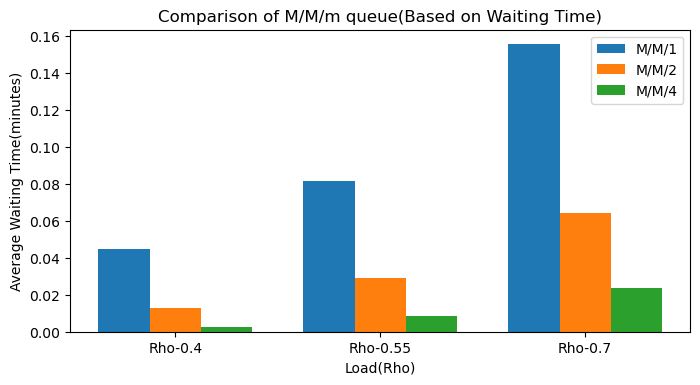

In [263]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=100)

rho_plot = [0.4,0.55,0.7]
num_server_plot = [1,2,4]

X = ['Rho-0.4','Rho-0.55','Rho-0.7']

X_axis = np.arange(len(X))

width = 0.25
  
plt.bar(X_axis , data[0:3], width, label = 'M/M/1')
plt.bar(X_axis + width, data[3:6], width, label = 'M/M/2')
plt.bar(X_axis + width*2, data[6:9], width, label = 'M/M/4')

plt.xlabel("Load(Rho)")
plt.ylabel('Average Waiting Time(minutes)')
plt.title("Comparison of M/M/m queue(Based on Waiting Time)")
  
plt.xticks(X_axis+width,['Rho-0.4','Rho-0.55','Rho-0.7'])

plt.legend()
plt.show()

In [ ]:
rho = lambd[0]/mu
wait = rho/(mu*(1-rho))
response = 1/(mu-lambd[0])
queue = rho**2/(1-rho)
cust = rho/(1-rho)


print(values)
print(wait)
print(response)
print(queue)
print(cust)

In [223]:
import pandas as pd 
pd.DataFrame(data).to_csv("file.csv")

500


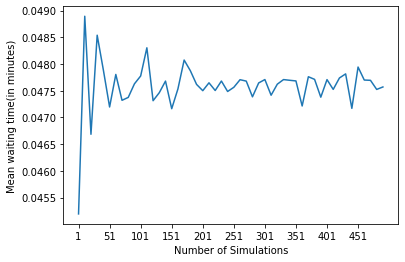

In [134]:
plt.plot(num_sim_arr,avg_time_sim)
#plt.yscale("log")

plt.xlabel("Number of Simulations")
plt.ylabel("Mean waiting time(in minutes)")

plt.xticks(np.arange(1, 500, 50))
plt.show()

# lambda = 25/4 = 6.25 customers per minute
# for 200 minutes - 1250 customers. 

0.04761904761904763
50


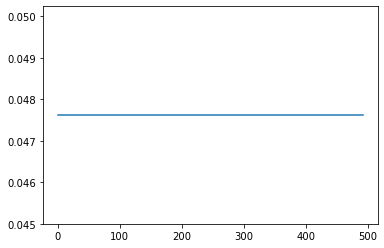

In [137]:
rho = lambd[0]/mu
th_wait = rho/(mu*(1-rho))
print(rho/(mu*(1-rho)))

print(len(num_sim_arr))

theoritical_avg_wait = np.empty(len(num_sim_arr))
theoritical_avg_wait.fill(th_wait)
plt.plot(num_sim_arr,theoritical_avg_wait)
plt.show()

# Average waiting time for 1,2 and 4 servers with the same load

In [12]:
# Distribution of mu(service rate)

# simpy works in minutes(lambda - number of arrivals per minute or appropriate change it in hours)
# Here system is a shop
# Agent is - Customer
# Process - serving
# resource - cashier/shopkeeper
class System(object):
    def __init__(self,env,num_servers,lambda_a,mu,service_distribution):
        self.env = env
        self.server = simpy.Resource(env,capacity = num_servers)
        self.n = 0    # Total customers inside the shop
        self.lambd = lambda_a
        self.mu = mu
        self.serDist = service_distribution
        self.waitTimes = []
        self.actual_wait = []
        self.customer = []
        
    
def customer(env,system):
    arrival_time = env.now
    #if()
    service_time = np.random.exponential(scale=1/system.mu)
    
    with system.server.request() as request_server:
        yield request_server
        
        waiting_time = env.now - arrival_time
        system.actual_wait.append(waiting_time)
   
        # Starts billing at the counter
        #print('starting to serve the customer at %s' % (env.now))
        yield env.timeout(service_time)
        #print('Customer has purchades goods and is leaving the store at %s' % (env.now))
            
    response_time = env.now - arrival_time
    system.waitTimes.append(response_time)
    #system.n  = system.n - 1
    #system.customer.append(system.n)
    
def generate(env,system):
    # shop opens at time 9:00 AM so time t = 0 and closes at 9:00 PM so T = 12
    while(env.now <= T_threshold):
        # First customer not arriving at time t = 0 but at inter_arrival time
        inter_arrival = np.random.exponential(scale=1/system.lambd)
        yield env.timeout(inter_arrival)
        env.process(customer(env,system))
        system.n += 1
        #system.customer.append(system.n)
        
def get_average_wait_time(wait_times):
    average_wait_time = np.mean(wait_times)
    return average_wait_time

q_length = []
def observe(env,system):
    while(env.now < T_threshold):
        q_length.append(len(system.server.queue))
        #print(len(system.server.queue))
        yield env.timeout(1.0)
        
        
        

service_distribution = "exponential"
avg_time = []


for i in range(len(num_servers)):
    for sim in range(num_sim):
        # Run the simulation
        env = simpy.Environment()
        system = System(env,num_servers[i],lambd[i],mu,service_distribution)
        env.process(generate(env,system))
        env.process(observe(env,system))
        env.run()
        avg_time.append(get_average_wait_time(system.actual_wait))
    #num_customers.append(system.n)
    print(num_servers[i])
    print(np.mean(avg_time))
    print('\n')
    
    

1
0.047341630931859086


2
0.030644490237042774


4
0.021410915820267294




# load of 0.66

In [20]:
num_sim = 200
T_threshold = 720 # 12 hours
random.seed(SEED)
num_servers = [1,2,4]

rho = 0.4
mu = 15      # per minute
lambd = [40/4,40/2,40]

print(40/(4*mu))

0.6666666666666666


In [21]:
# Distribution of mu(service rate)

# simpy works in minutes(lambda - number of arrivals per minute or appropriate change it in hours)
# Here system is a shop
# Agent is - Customer
# Process - serving
# resource - cashier/shopkeeper
class System(object):
    def __init__(self,env,num_servers,lambda_a,mu,service_distribution):
        self.env = env
        self.server = simpy.Resource(env,capacity = num_servers)
        self.n = 0    # Total customers inside the shop
        self.lambd = lambda_a
        self.mu = mu
        self.serDist = service_distribution
        self.waitTimes = []
        self.actual_wait = []
        self.customer = []
        
    
def customer(env,system):
    arrival_time = env.now
    #if()
    service_time = np.random.exponential(scale=1/system.mu)
    
    with system.server.request() as request_server:
        yield request_server
        
        waiting_time = env.now - arrival_time
        system.actual_wait.append(waiting_time)
   
        # Starts billing at the counter
        #print('starting to serve the customer at %s' % (env.now))
        yield env.timeout(service_time)
        #print('Customer has purchades goods and is leaving the store at %s' % (env.now))
            
    response_time = env.now - arrival_time
    system.waitTimes.append(response_time)
    #system.n  = system.n - 1
    #system.customer.append(system.n)
    
def generate(env,system):
    # shop opens at time 9:00 AM so time t = 0 and closes at 9:00 PM so T = 12
    while(env.now <= T_threshold):
        # First customer not arriving at time t = 0 but at inter_arrival time
        inter_arrival = np.random.exponential(scale=1/system.lambd)
        yield env.timeout(inter_arrival)
        env.process(customer(env,system))
        system.n += 1
        #system.customer.append(system.n)
        
def get_average_wait_time(wait_times):
    average_wait_time = np.mean(wait_times)
    return average_wait_time

q_length = []
def observe(env,system):
    while(env.now < T_threshold):
        q_length.append(len(system.server.queue))
        #print(len(system.server.queue))
        yield env.timeout(1.0)
        
        
        

service_distribution = "exponential"
avg_time = []


for i in range(len(num_servers)):
    for sim in range(num_sim):
        # Run the simulation
        env = simpy.Environment()
        system = System(env,num_servers[i],lambd[i],mu,service_distribution)
        env.process(generate(env,system))
        env.process(observe(env,system))
        env.run()
        avg_time.append(get_average_wait_time(system.actual_wait))
    #num_customers.append(system.n)
    print(num_servers[i])
    print(np.mean(avg_time))
    print('\n')
    
    

1
0.13420475493974698


2
0.09384146702155743


4
0.06888423803589734




# Graph of convergence of waiting time with increase in simulation runs(M/M/1)

# Average Response time

In [32]:
num_sim_arr = [10,50,100,200,350,500,800,1000,1200,1500,2000,3000,4000]
T_threshold = 720 # 12 hours
random.seed(SEED)
num_servers = 1

rho = 0.4
mu = 15      # per minute
lambd = 25/4


In [34]:
# Distribution of mu(service rate)

# simpy works in minutes(lambda - number of arrivals per minute or appropriate change it in hours)
# Here system is a shop
# Agent is - Customer
# Process - serving
# resource - cashier/shopkeeper
class System(object):
    def __init__(self,env,num_servers,lambda_a,mu,service_distribution):
        self.env = env
        self.server = simpy.Resource(env,capacity = num_servers)
        self.n = 0    # Total customers inside the shop
        self.lambd = lambda_a
        self.mu = mu
        self.serDist = service_distribution
        self.waitTimes = []
        self.actual_wait = []
        self.customer = []
        
    
def customer(env,system):
    arrival_time = env.now
    #if()
    service_time = np.random.exponential(scale=1/system.mu)
    
    with system.server.request() as request_server:
        yield request_server
        
        waiting_time = env.now - arrival_time
        system.actual_wait.append(waiting_time)
   
        # Starts billing at the counter
        #print('starting to serve the customer at %s' % (env.now))
        yield env.timeout(service_time)
        #print('Customer has purchades goods and is leaving the store at %s' % (env.now))
            
    response_time = env.now - arrival_time
    system.waitTimes.append(response_time)
    #system.n  = system.n - 1
    #system.customer.append(system.n)
    
def generate(env,system):
    # shop opens at time 9:00 AM so time t = 0 and closes at 9:00 PM so T = 12
    while(env.now <= T_threshold):
        # First customer not arriving at time t = 0 but at inter_arrival time
        inter_arrival = np.random.exponential(scale=1/system.lambd)
        yield env.timeout(inter_arrival)
        env.process(customer(env,system))
        system.n += 1
        #system.customer.append(system.n)
        
def get_average_wait_time(wait_times):
    average_wait_time = np.mean(wait_times)
    return average_wait_time

q_length = []
def observe(env,system):
    while(env.now < T_threshold):
        q_length.append(len(system.server.queue))
        #print(len(system.server.queue))
        yield env.timeout(1.0)
        
        
        

service_distribution = "exponential"
avg_time = []
avg_timt_y = []


for num_sim in num_sim_arr:
    for sim in range(num_sim):
        # Run the simulation
        env = simpy.Environment()
        system = System(env,num_servers,lambd,mu,service_distribution)
        env.process(generate(env,system))
        env.process(observe(env,system))
        env.run()
        avg_time.append(get_average_wait_time(system.actual_wait))
    #num_customers.append(system.n)
    avg_timt_y.append(np.mean(avg_time))
    print(num_servers)
    #print(np.mean(avg_time))
    print('\n')
    
    

1


1


1


1


1


1


1


1


1


1


1


1


1




In [35]:
print(avg_timt_y)

[0.04733841807256124, 0.04734163675523396, 0.047673420306026684, 0.04755649672200987, 0.047544711927646276, 0.047464819509879956, 0.047519032362241725, 0.04755488828452877, 0.047527689930453795, 0.047528369020399835, 0.04752339822078653, 0.04755945590805764, 0.04755695892568142]


In [42]:
rho = lambd/mu
print(rho/(mu*(1-rho)))

0.04761904761904763


In [68]:
avg_time_y = [0.04733841807256124, 0.04734163675523396, 0.047673420306026684, 0.04755649672200987, 0.047544711927646276, 0.047464819509879956, 0.047519032362241725, 0.04755488828452877, 0.047527689930453795, 0.047528369020399835, 0.04752339822078653, 0.04755945590805764, 0.04755695892568142]

In [51]:
print(avg_time_y)

[0.04733841807256124, 0.04734163675523396, 0.047673420306026684, 0.04755649672200987, 0.047544711927646276, 0.047464819509879956, 0.047519032362241725, 0.04755488828452877, 0.047527689930453795, 0.047528369020399835, 0.04752339822078653, 0.04755945590805764, 0.04755695892568142]


In [60]:
print(len(avg_time_y))

13


In [69]:
for i in range(len(avg_time_y)) :
    avg_time_y[i] = 60*avg_time_y[i]
print(avg_time_y)

print(0.04761904761904763*60)

[2.8403050843536746, 2.8404982053140375, 2.860405218361601, 2.853389803320592, 2.8526827156587764, 2.8478891705927976, 2.8511419417345034, 2.853293297071726, 2.851661395827228, 2.8517021412239902, 2.8514038932471917, 2.8535673544834586, 2.853417535540885]
2.8571428571428577


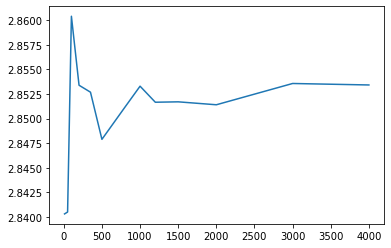

In [65]:
plt.plot(num_sim_arr,avg_time_y)
#plt.yscale("log")

# Probability distribution of mean waiting time 
system more stable with 

Increase in customer number our markov model becomes more stable
(or observe for a longer period of time)

# Confidence Interval

$ \bar{X}_{j+1} = \bar{X}_{j} + \frac{X_{j+1} - \bar{X}_{j}}{j+1} $


$ {S}_{j+1}^{2} = (1-\frac{1}{j})S_{j}^{2}+(j+1)(\bar{X}_{j+1} - \bar{X}_{j})^{2} $

In [ ]:
%%time

num_sim = 100    # number of simulations to run``


avg_timt_y = []
avg_waiting_time = []

def run_simulation():
    env = simpy.Environment()
    system = System(env,num_servers,lambd,mu,service_distribution)
    env.process(generate(env,system))
    env.process(observe(env,system))
    env.run()
    return get_average_wait_time(system.actual_wait)



for sim in range(num_sim):
        avg_wait = run_simulation()
        avg_waiting_time.append(avg_wait)
        
# Estimators - mean and variance(unbiased)
        
prev_estimated_mean = sum(avg_waiting_time)/num_sim
        
mean_difference = 0

for i in range(num_sim):
    mean_difference += (avg_waiting_time[i]-prev_estimated_mean)**2
    
prev_estimated_variance = mean_difference/(num_sim-1)


l = 0.015
z = 1.96
estimated_std_deviation = np.sqrt(prev_estimated_variance)
acceptable_window = 2*z*estimated_std_deviation/np.sqrt(n_sim)
print(acceptable_window)



In [28]:
num_sim = 200
T_threshold = 720 # 12 hours
random.seed(SEED)
num_servers = [1,2,4]

rho = 0.4
mu = 15      # per minute
lambd = [40/4,40/2,40]

print(40/(4*mu))

0.6666666666666666


In [29]:
# Distribution of mu(service rate)

# simpy works in minutes(lambda - number of arrivals per minute or appropriate change it in hours)
# Here system is a shop
# Agent is - Customer
# Process - serving
# resource - cashier/shopkeeper
class System(object):
    def __init__(self,env,num_servers,lambda_a,mu,service_distribution):
        self.env = env
        self.numServer = num_servers
        self.server = simpy.Resource(env,capacity = num_servers)
        self.n = 0    # Total customers inside the shop
        self.lambd = lambda_a
        self.mu = mu
        self.serDist = service_distribution
        self.waitTimes = []
        self.actual_wait = []
        self.customer = []
        
    
def customer(env,system):
    arrival_time = env.now
    #if()
    service_time = np.random.exponential(scale=1/system.mu)
    
    with system.server.request() as request_server:
        yield request_server
        
        waiting_time = env.now - arrival_time
        system.actual_wait.append(waiting_time)
   
        # Starts billing at the counter
        #print('starting to serve the customer at %s' % (env.now))
        yield env.timeout(service_time)
        #print('Customer has purchades goods and is leaving the store at %s' % (env.now))
            
    response_time = env.now - arrival_time
    system.waitTimes.append(response_time)
    system.n  = system.n - 1
    #system.customer.append(system.n)
    
def generate(env,system):
    # shop opens at time 9:00 AM so time t = 0 and closes at 9:00 PM so T = 12
    while(env.now <= T_threshold):
        # First customer not arriving at time t = 0 but at inter_arrival time
        inter_arrival = np.random.exponential(scale=1/system.lambd)
        yield env.timeout(inter_arrival)
        env.process(customer(env,system))
        system.n += 1
        #system.customer.append(system.n)
        
def get_average_wait_time(wait_times):
    average_wait_time = np.mean(wait_times)
    return average_wait_time

q_length = []
resource_utilization_fraction = []
def observe(env,system):
    while(env.now < T_threshold):
        q_length.append(len(system.server.queue))
        if(system.server.count < system.numServer):
            
            resource_utilization_fraction.append(system.server.count/system.numServer)   
        
        else:
            resource_utilization_fraction.append(1)
        #print(len(system.server.queue))
        yield env.timeout(1.0)
        
        
        

service_distribution = "exponential"
avg_response_time = []
avg_utilization = []

for i in range(len(num_servers)):
    for sim in range(num_sim):
        # Run the simulation
        env = simpy.Environment()
        system = System(env,num_servers[i],lambd[i],mu,service_distribution)
        env.process(generate(env,system))
        env.process(observe(env,system))
        env.run()
        avg_response_time.append(get_average_wait_time(system.waitTimes))
        avg_utilization.append(get_average_wait_time(resource_utilization_fraction))
        
    #num_customers.append(system.n)
    print(num_servers[i])
    print(np.mean(avg_response_time))
    print(np.mean(avg_utilization))
    print('\n')
    
    

1
0.20063634670643457
0.6675345342989139


2
0.1602202152809511
0.6674283842722035


4
0.13533865655957542
0.6670094846805381




In [16]:
for i in range(len(lambd)):
    print(rho/((1-rho)*lambd[i]))

0.10666666666666667
0.05333333333333334
0.02666666666666667


In [ ]:
for sim in range(num_sim):
    # Run the simulation
    env = simpy.Environment()
    system = System(env, num_servers_single, lambda_a_single,mu,service_distribution)
    env.process(generate(env,system))
    env.run()
    avg_time.append(get_average_wait_time(system.waitTimes))
    #num_customers.append(system.n)
    
print(np.mean(avg_time))
#print(num_customers)

In [46]:
cust = []

for sim in range(num_sim):
    # Run the simulation
    env = simpy.Environment()
    system = System(env, num_servers_single, lambda_a_single,mu,service_distribution)
    env.process(generate(env,system))
    env.run()
    cust.append(get_average_wait_time(system.customer))
    #num_customers.append(system.n)
    
print(np.mean(cust))
#print(num_customers)

0.9992988229424623


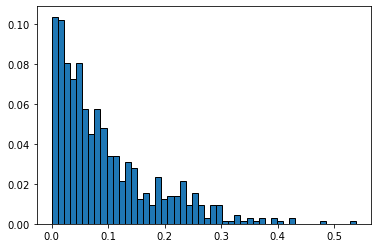

0
1.0069551777434311
0.49999999999999994
0


In [42]:
rho = lambda_a_single/(mu)
env = simpy.Environment()
system = System(env, num_servers_single, lambda_a_single,mu,service_distribution)
env.process(generate(env,system))
env.run()
weights = np.ones_like(system.waitTimes) / len(system.waitTimes)
plt.hist(system.waitTimes,weights=weights, bins= 50, edgecolor='black')
plt.show()

print(system.n)
print(get_average_wait_time(system.customer))
print(rho/(1-rho))
print(system.n)

# response time follows exponential distribution


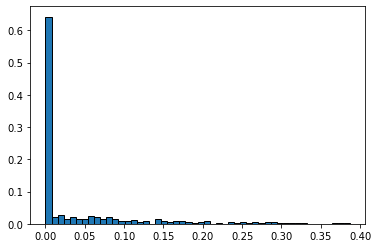

In [33]:
env = simpy.Environment()
system = System(env, num_servers_single, lambda_a_single,mu,service_distribution)
env.process(generate(env,system))
env.run()
weights = np.ones_like(system.actual_wait) / len(system.actual_wait)
plt.hist(system.actual_wait,weights=weights, bins= 50, edgecolor='black')
plt.show()

# doesn't follow exponential distribution

In [4]:
0.008571522311735998
0.03307090256445418


0.07483901532100676
0.1001360999041171







0.5


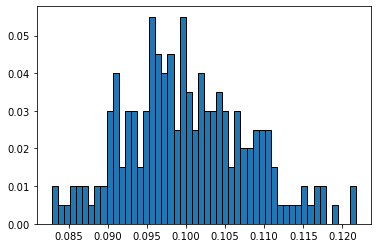

In [28]:
weights = np.ones_like(avg_time) / len(avg_time)
plt.hist(avg_time,weights=weights, bins= 50, edgecolor='black')
plt.show()

# mean waiting time probability distribution graph for different N and different different number of servers - FIFO,determinitis,shortest time
# different load -  different waiting times
# same load, different serevrs waiting time 

In [30]:
from scipy import stats
k2, p = stats.normaltest(avg_time)
alpha = 1e-3
print(p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print(100*(1-alpha))

0.21033763215191809
The null hypothesis cannot be rejected
99.9


In [ ]:
# If not enough workers/servers then high wait time

# Black friday - High lambda 
Resource allocation should be proper - need to appoint more workers 
# less Lambda - idle servers ? 


# Vary lambda, mu , num_servers to see how the system behaves

In [ ]:
Simulation is all about creating a virtual environment to reflect a real-world system